In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import os
import pandas as pd
from shapely.ops import unary_union

In [2]:
# define the place name for the west midlands area
place_name = "West midlands, UK"
# download the road network data from osmnx from the OSM API
RoadNetworkGraph = ox.graph_from_place(place_name, network_type='drive')
print(f"Original CRS: {RoadNetworkGraph.graph['crs']}")
# project the road network to the British National Grid (EPSG:27700)
RoadNetworkGraph_projected = ox.project_graph(RoadNetworkGraph, to_crs='EPSG:27700')
# check the CRS
print(f"Projected CRS: {RoadNetworkGraph_projected.graph['crs']}")

Original CRS: epsg:4326
Projected CRS: EPSG:27700


In [3]:
# check how many nodes and edges in the graph
print(f"Number of nodes: {len(RoadNetworkGraph_projected.nodes)}")
print(f"Number of edges: {len(RoadNetworkGraph_projected.edges)}")

Number of nodes: 83323
Number of edges: 184282


In [4]:
# check if the network is a directed graph
print(f"Is the graph directed? {nx.is_directed(RoadNetworkGraph_projected)}")
# change the graph to an undirected graph
RoadNetworkGraph_undirected = RoadNetworkGraph_projected.to_undirected()
# check if the network is fully connected
print(f"Is the graph fully connected? {nx.is_connected(RoadNetworkGraph_undirected)}")

Is the graph directed? True
Is the graph fully connected? True


In [5]:
import pulp
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
import numpy as np
from scipy.spatial.distance import cdist

In [6]:
# import the boundary of the west midlands area
Area_boundary = gpd.read_file(os.path.join("data/westmidslands/westmidlands.shp"))


In [7]:
# check area_boundary's crs
print(f"Area_boundary's CRS: {Area_boundary.crs}")

Area_boundary's CRS: EPSG:27700


**Generate Candidate Points**

In [8]:
# let us generate a grid of points within the boundary of the west midlands area
polygon = Area_boundary.geometry.iloc[0]

# define the grid spacing (1000 meters)
grid_spacing = 1000  # 1000 meters

# get the bounds of the polygon
minx, miny, maxx, maxy = polygon.bounds

# generate the x and y coordinates for the grid points
x_coords = np.arange(minx, maxx, grid_spacing)
y_coords = np.arange(miny, maxy, grid_spacing)
grid_points = [Point(x, y) for x in x_coords for y in y_coords]

# filter out the points that are outside the polygon
points_within_polygon = [point for point in grid_points if polygon.contains(point)]

# create a geodataframe for the points
Candidate_points_1000_gdf = gpd.GeoDataFrame(geometry=points_within_polygon, crs=Area_boundary.crs)

# let the index of the candidate points be the candidate point id
Candidate_points_1000_gdf['candidate_point_id'] = Candidate_points_1000_gdf.index
Candidate_points_1000_gdf.columns

#convert the Candidate_points_1000_gdf, a geopandas frame, back to a pandas dataframe where transform the geometry to two columns of northing and easting with the crs 27700

Candidate_points_1000_gdf['northing'] = Candidate_points_1000_gdf.geometry.y
Candidate_points_1000_gdf['easting'] = Candidate_points_1000_gdf.geometry.x
Candidate_points_1000_df = pd.DataFrame(Candidate_points_1000_gdf)
Candidate_points_1000_df = Candidate_points_1000_df.drop(columns=['geometry'])
Candidate_points_1000_df = Candidate_points_1000_df[['candidate_point_id', 'northing', 'easting']]

# print the shape of the candidate points
print(f"Number of candidate points: {Candidate_points_1000_df.shape[0]}")
# print the maximum candidate point id
print(f"Maximum candidate point id: {Candidate_points_1000_df['candidate_point_id'].max()}")

Number of candidate points: 897
Maximum candidate point id: 896


In [9]:
Candidate_points_1000_df.sample(5)

,candidate_point_id,northing,easting
553,553,275206.9008,412080.4982
625,625,294206.9008,414080.4982
830,830,277206.9008,431080.4982
153,153,286206.9008,396080.4982
885,885,279206.9008,437080.4982


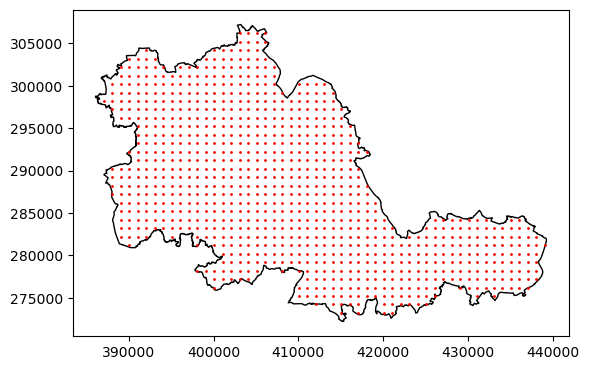

In [10]:

# visualize the candidate grid points and the boundary of the west midlands area
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
Area_boundary.plot(ax=ax, edgecolor='black', facecolor='none')
Candidate_points_1000_gdf.plot(ax=ax, color='red', markersize=1)
plt.show()

**Generate demands points**

In [11]:
# import the demandpoints csv data
DemandPoints_raw = pd.read_csv("data/processed/mobilisation.csv")

In [12]:
DemandPoints2 = DemandPoints_raw[DemandPoints_raw['call_year'] == 2023][['EASTINGS','NORTHINGS','incident_profile_label']].sample(2000, random_state=1)
# reset the DemandPoints2 index to start from 0
DemandPoints2.reset_index(drop=True, inplace=True)
# change the column names of DemandPoints2 from 'EASTINGS' to 'easting' and 'NORTHINGS' to 'northing'
DemandPoints2.columns = ['easting', 'northing', 'incident_profile_label']
# set the column'demand_points_id' as the index
DemandPoints2['demand_points_id'] = DemandPoints2.index
DemandPoints = DemandPoints2.copy()

# print the shape of the candidate points
print(f"Number of demand points: {DemandPoints.shape[0]}")
# print the maximum candidate point id
print(f"Maximum demand point id: {DemandPoints['demand_points_id'].max()}")

Number of demand points: 2000
Maximum demand point id: 1999


In [14]:
DemandPoints.columns

Index(['easting', 'northing', 'incident_profile_label', 'demand_points_id'], dtype='object')

In [19]:
# conver the DemandPoints, a pandas dataframe, to a geopandas dataframe with the crs 27700  
DemandPoints_gdf = gpd.GeoDataFrame(DemandPoints, geometry=gpd.points_from_xy(DemandPoints.easting, DemandPoints.northing), crs='EPSG:27700')
DemandPoints_gdf = DemandPoints_gdf.drop(columns=['easting', 'northing'])


In [ ]:
DemandPoints_gdf.explore()

**Generate the current point**

In [21]:
station_csv = pd.read_csv("data/processed/station_locations_38.csv")
station_csv.head(4)

,Station name,Easting,Northing,PRL_Count,BRV_Count,Closed (Y/N),Opened,Closed
0,Aldridge,405203,302818,1,0,N,Before study period,NaN
1,Aston,407316,289711,1,1,N,Before study period,NaN
2,Bickenhill,419627,284038,1,0,N,Before study period,NaN
3,Billesley,409029,281369,1,1,N,Before study period,NaN


In [22]:
station_points_38 = station_csv[['Easting', 'Northing']]
# change the column names of station_points_38 from 'Easting' to 'easting' and 'Northing' to 'northing'
station_points_38.columns = ['easting', 'northing']
station_points_38['current_id'] = station_points_38.index
station_points_38 = station_points_38[['current_id', 'easting', 'northing']]
station_points_38.sample(5)

C:\Users\SBH\AppData\Local\Temp\ipykernel_20348\2850928818.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_points_38['current_id'] = station_points_38.index


,current_id,easting,northing
12,12,411277,292051
14,14,434545,282370
4,4,394543,296040
27,27,390368,284156
23,23,408405,293078


**calculate Euclidean Distance**

In [17]:
# calculate the euclidean distance between each candidate points and demands points
coords1_demand = DemandPoints[['northing', 'easting']].values
coords2_candidate = Candidate_points_1000_df[['northing', 'easting']].values
coords3_current = station_points_38[['northing', 'easting']].values
distance_matrix_candi = cdist(coords1_demand, coords2_candidate, metric='euclidean')
disatance_matrix_current = cdist(coords1_demand, coords3_current, metric='euclidean')

In [18]:
# 合并已有设施点和候选位置的距离矩阵
distance_matrix = np.hstack((disatance_matrix_current, distance_matrix_candi))
# 对矩阵内的所有元素进行取整操作
distance_matrix = np.round(distance_matrix, 0)

In [18]:
# 假设有2000个需求点
demand_points = list(range(2000))

# 现有的设施点位置
current_facilities = list(range(38))  # 设施点0到37
# 需要重新选址的设施点数量
n_relocate = 1
# 候选位置（897个）
candidate_locations = list(range(38, 934))  # 设施点38到934，共897个

# 初始化优化问题
problem = pulp.LpProblem("P-Median_Problem_with_Relocation", pulp.LpMinimize)

# 定义决策变量
# 包含现有设施点和候选设施点的所有位置
all_facilities = current_facilities + candidate_locations
x = pulp.LpVariable.dicts("Facility", all_facilities, 0, 1, pulp.LpBinary)
y = pulp.LpVariable.dicts("Assign", (demand_points, all_facilities), 0, 1, pulp.LpBinary)

# 添加目标函数：最小化总距离
problem += pulp.lpSum(distance_matrix[i][j] * y[i][j] for i in demand_points for j in all_facilities)

# 添加约束条件
for i in demand_points:
    problem += pulp.lpSum(y[i][j] for j in all_facilities) == 1  # 每个需求点必须分配给一个设施

for j in all_facilities:
    for i in demand_points:
        problem += y[i][j] <= x[j]  # 只能分配给已选定的设施

# 保证重新选址的设施数量
problem += pulp.lpSum(x[j] for j in candidate_locations) == n_relocate

# 确保现有的部分设施位置固定不变
for facility in current_facilities:
    problem += x[facility] == 1

# 求解问题
problem.solve()

# 输出结果
print("Status:", pulp.LpStatus[problem.status])
print("Selected Facilities:")
for j in candidate_locations:
    if pulp.value(x[j]) == 1:
        print(f"Facility at candidate location {j}")

# 输出需求点分配
"""
print("\nDemand point assignments:")
for i in demand_points:
    for j in all_facilities:
        if pulp.value(y[i][j]) == 1:
            print(f"Demand point {i} assigned to facility {j}")
"""

Status: Optimal
Selected Facilities:
Facility at candidate location 481


'\nprint("\nDemand point assignments:")\nfor i in demand_points:\n    for j in all_facilities:\n        if pulp.value(y[i][j]) == 1:\n            print(f"Demand point {i} assigned to facility {j}")\n'

In [24]:
Candidate_points_1000_df[Candidate_points_1000_df['candidate_point_id']==481]

,candidate_point_id,northing,easting
481,481,279206.9008,409080.4982


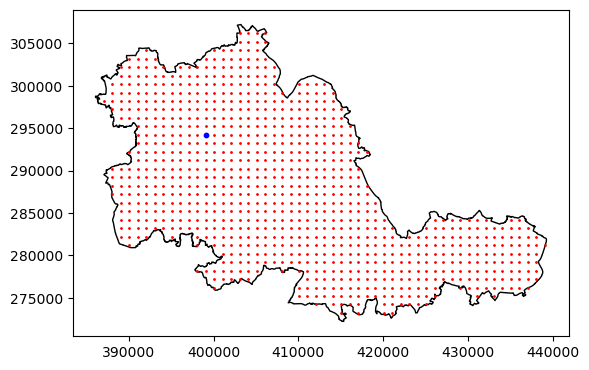

In [51]:
# plot this point on the map
fig, ax = plt.subplots()
Area_boundary.plot(ax=ax, edgecolor='black', facecolor='none')
Candidate_points_1000_gdf.plot(ax=ax, color='red', markersize=1)
plt.scatter(409080, 279207, color='blue', s=10)
plt.show()

In [20]:
# 假设有2000个需求点
demand_points = list(range(2000))

# 现有的设施点位置
current_facilities = list(range(38))  # 设施点0到37
# 需要重新选址的设施点数量
n_relocate = 2
# 候选位置（897个）
candidate_locations = list(range(38, 934))  # 设施点38到934，共897个

# 初始化优化问题
problem = pulp.LpProblem("P-Median_Problem_with_Relocation", pulp.LpMinimize)

# 定义决策变量
# 包含现有设施点和候选设施点的所有位置
all_facilities = current_facilities + candidate_locations
x = pulp.LpVariable.dicts("Facility", all_facilities, 0, 1, pulp.LpBinary)
y = pulp.LpVariable.dicts("Assign", (demand_points, all_facilities), 0, 1, pulp.LpBinary)

# 添加目标函数：最小化总距离
problem += pulp.lpSum(distance_matrix[i][j] * y[i][j] for i in demand_points for j in all_facilities)

# 添加约束条件
for i in demand_points:
    problem += pulp.lpSum(y[i][j] for j in all_facilities) == 1  # 每个需求点必须分配给一个设施

for j in all_facilities:
    for i in demand_points:
        problem += y[i][j] <= x[j]  # 只能分配给已选定的设施

# 保证重新选址的设施数量
problem += pulp.lpSum(x[j] for j in candidate_locations) == n_relocate

# 确保现有的部分设施位置固定不变
for facility in current_facilities:
    problem += x[facility] == 1

# 求解问题
problem.solve()

# 输出结果
print("Status:", pulp.LpStatus[problem.status])
print("Selected Facilities:")
for j in candidate_locations:
    if pulp.value(x[j]) == 1:
        print(f"Facility at candidate location {j}")

# 输出需求点分配
"""
print("\nDemand point assignments:")
for i in demand_points:
    for j in all_facilities:
        if pulp.value(y[i][j]) == 1:
            print(f"Demand point {i} assigned to facility {j}")
"""

Status: Optimal
Selected Facilities:
Facility at candidate location 481
Facility at candidate location 685


'\nprint("\nDemand point assignments:")\nfor i in demand_points:\n    for j in all_facilities:\n        if pulp.value(y[i][j]) == 1:\n            print(f"Demand point {i} assigned to facility {j}")\n'

In [21]:
Candidate_points_1000_df[Candidate_points_1000_df['candidate_point_id']==481]

,candidate_point_id,northing,easting
481,481,279206.9008,409080.4982


In [22]:
Candidate_points_1000_df[Candidate_points_1000_df['candidate_point_id']==685]

,candidate_point_id,northing,easting
685,685,280206.9008,417080.4982


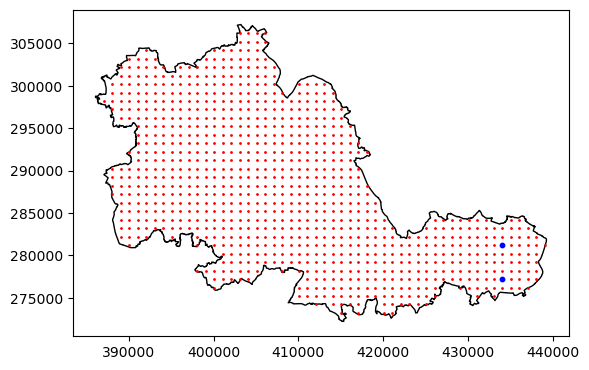

In [54]:
# plot this point on the map
fig, ax = plt.subplots()
Area_boundary.plot(ax=ax, edgecolor='black', facecolor='none')
Candidate_points_1000_gdf.plot(ax=ax, color='red', markersize=1)
plt.scatter(409080, 279207, color='blue', s=10)
plt.scatter(417080, 280207, color='blue', s=10)
plt.show()

In [23]:
# 假设有2000个需求点
demand_points = list(range(2000))

# 现有的设施点位置
current_facilities = list(range(38))  # 设施点0到37
# 需要重新选址的设施点数量
n_relocate = 3
# 候选位置（897个）
candidate_locations = list(range(38, 934))  # 设施点38到934，共897个

# 初始化优化问题
problem = pulp.LpProblem("P-Median_Problem_with_Relocation", pulp.LpMinimize)

# 定义决策变量
# 包含现有设施点和候选设施点的所有位置
all_facilities = current_facilities + candidate_locations
x = pulp.LpVariable.dicts("Facility", all_facilities, 0, 1, pulp.LpBinary)
y = pulp.LpVariable.dicts("Assign", (demand_points, all_facilities), 0, 1, pulp.LpBinary)

# 添加目标函数：最小化总距离
problem += pulp.lpSum(distance_matrix[i][j] * y[i][j] for i in demand_points for j in all_facilities)

# 添加约束条件
for i in demand_points:
    problem += pulp.lpSum(y[i][j] for j in all_facilities) == 1  # 每个需求点必须分配给一个设施

for j in all_facilities:
    for i in demand_points:
        problem += y[i][j] <= x[j]  # 只能分配给已选定的设施

# 保证重新选址的设施数量
problem += pulp.lpSum(x[j] for j in candidate_locations) == n_relocate

# 确保现有的部分设施位置固定不变
for facility in current_facilities:
    problem += x[facility] == 1

# 求解问题
problem.solve()

# 输出结果
print("Status:", pulp.LpStatus[problem.status])
print("Selected Facilities:")
for j in candidate_locations:
    if pulp.value(x[j]) == 1:
        print(f"Facility at candidate location {j}")

Status: Optimal
Selected Facilities:
Facility at candidate location 375
Facility at candidate location 481
Facility at candidate location 685


In [29]:
Candidate_points_1000_df[Candidate_points_1000_df['candidate_point_id']==375]

,candidate_point_id,northing,easting
375,375,303206.9008,404080.4982


In [28]:
Candidate_points_1000_df[Candidate_points_1000_df['candidate_point_id']==481]

,candidate_point_id,northing,easting
481,481,279206.9008,409080.4982


In [27]:
Candidate_points_1000_df[Candidate_points_1000_df['candidate_point_id']==685]

,candidate_point_id,northing,easting
685,685,280206.9008,417080.4982


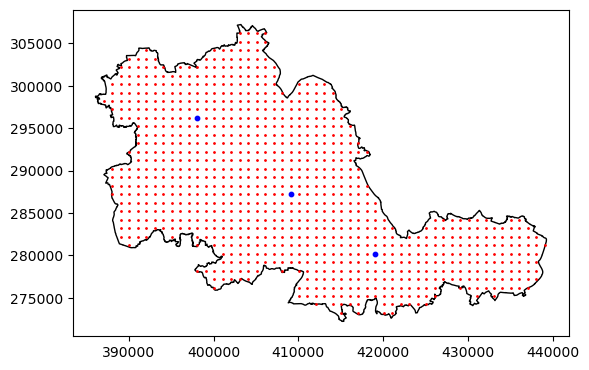

In [59]:
# plot this point on the map
fig, ax = plt.subplots()
Area_boundary.plot(ax=ax, edgecolor='black', facecolor='none')
Candidate_points_1000_gdf.plot(ax=ax, color='red', markersize=1)
plt.scatter(404080, 303207, color='blue', s=10)
plt.scatter(409080, 279207, color='blue', s=10)
plt.scatter(417080, 280207, color='blue', s=10)
plt.show()

In [19]:
# 假设有2000个需求点
demand_points = list(range(2000))

# 所有设施点位置（假设现有设施点位置也在0到37之间）
all_facilities = list(range(934))  # 设施点0到933，共934个

# 需要重新选址的设施点数量
n_relocate = 38

# 初始化优化问题
problem = pulp.LpProblem("P-Median_Problem_with_Relocation", pulp.LpMinimize)

# 定义决策变量
x = pulp.LpVariable.dicts("Facility", all_facilities, 0, 1, pulp.LpBinary)
y = pulp.LpVariable.dicts("Assign", (demand_points, all_facilities), 0, 1, pulp.LpBinary)

# 添加目标函数：最小化总距离
problem += pulp.lpSum(distance_matrix[i][j] * y[i][j] for i in demand_points for j in all_facilities)

# 添加约束条件
for i in demand_points:
    problem += pulp.lpSum(y[i][j] for j in all_facilities) == 1  # 每个需求点必须分配给一个设施

for j in all_facilities:
    for i in demand_points:
        problem += y[i][j] <= x[j]  # 只能分配给已选定的设施

# 保证选址的设施数量为38
problem += pulp.lpSum(x[j] for j in all_facilities) == n_relocate

# 求解问题
problem.solve()

# 输出结果
print("Status:", pulp.LpStatus[problem.status])
print("Selected Facilities:")

# 创建DataFrame
data = []
for j in all_facilities:
    if pulp.value(x[j]) == 1:
        print(f"Facility at location {j}")
        data.append([j])
df = pd.DataFrame(data, columns=['facility_id'])

Status: Optimal
Selected Facilities:
Facility at location 15
Facility at location 76
Facility at location 84
Facility at location 87
Facility at location 122
Facility at location 138
Facility at location 155
Facility at location 205
Facility at location 220
Facility at location 258
Facility at location 276
Facility at location 287
Facility at location 307
Facility at location 319
Facility at location 322
Facility at location 325
Facility at location 368
Facility at location 389
Facility at location 442
Facility at location 449
Facility at location 453
Facility at location 457
Facility at location 482
Facility at location 488
Facility at location 504
Facility at location 542
Facility at location 546
Facility at location 554
Facility at location 603
Facility at location 612
Facility at location 625
Facility at location 675
Facility at location 685
Facility at location 747
Facility at location 851
Facility at location 889
Facility at location 907
Facility at location 922


In [23]:
df

,facility_id
0,15
1,76
2,84
3,87
4,122
5,138
6,155
7,205
8,220
9,258


In [26]:
Candidate_points_1000_df_1 = Candidate_points_1000_df.copy()
# drop the 'points_id'  column
Candidate_points_1000_df_1.drop(columns=['candidate_point_id'], inplace=True)
Candidate_points_1000_df_1.head(5)

,northing,easting
0,298206.9008,387080.4982
1,287206.9008,388080.4982
2,288206.9008,388080.4982
3,289206.9008,388080.4982
4,290206.9008,388080.4982


In [24]:
station_points_38.columns

Index(['current_id', 'easting', 'northing'], dtype='object')

In [25]:
station_points_38_1 = station_points_38.copy()
# drop the 'current_id' column
station_points_38_1.drop(columns=['current_id'], inplace=True)

,easting,northing
0,405203,302818
1,407316,289711
2,419627,284038
3,409029,281369


In [28]:
# change the sequence of the columns in the station_points_38_1 dataframe
station_points_38_1 = station_points_38_1[['northing', 'easting']]
station_points_38_1.head(4)


,northing,easting
0,302818,405203
1,289711,407316
2,284038,419627
3,281369,409029


In [30]:
# concatenate the Candidate_points_1000_df_1 and station_points_38_1 dataframes
all_points_937 = pd.concat([station_points_38_1, Candidate_points_1000_df_1], axis=0)
all_points_937

,northing,easting
0,302818.0000,405203.0000
1,289711.0000,407316.0000
2,284038.0000,419627.0000
3,281369.0000,409029.0000
4,296040.0000,394543.0000
...,...,...
892,279206.9008,438080.4982
893,280206.9008,438080.4982
894,281206.9008,438080.4982
895,282206.9008,438080.4982


In [35]:
selected_facilities = pd.read_csv("data/processed/selected_facility_locations_38.csv")
# convert the 'facility_id' columne to a list
selected_facilities_list = selected_facilities['facility_id'].tolist()


In [37]:
# filter out the selected facilities from the all_points_937 dataframe
selected_facilities_df = all_points_937[all_points_937.index.isin(selected_facilities_list)]
# convert the selected_facilities_df to a geodataframe
selected_facilities_gdf = gpd.GeoDataFrame(selected_facilities_df, geometry=gpd.points_from_xy(selected_facilities_df.easting, selected_facilities_df.northing), crs='EPSG:27700')

In [39]:
# save the selected_facilities_gdf to a shapefile
selected_facilities_gdf.to_file("data/processed/selected_facility_locations_38.shp")

In [38]:
selected_facilities_gdf.explore()

In [21]:
df.to_csv('data/processed/selected_facility_locations_38.csv', index=False)